In [1]:
import torch
import torch.nn as nn
from comet_ml.logging_extensions.rich_decoration.environment import height
from torchvision.ops import generalized_box_iou
import torch.nn.functional as F
from scipy.optimize import linear_sum_assignment
from typing import Tuple
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import random
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [2]:
def cxcywh_to_xyxy(boxes):
    cx, cy, w, h = boxes.unbind(-1)
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    return torch.stack((x1, y1, x2, y2), dim=-1)

In [3]:
class HungarianMatcher(nn.Module):
    def __init__(self, cost_class: float = 1, cost_bbox: float = 1, cost_giou: float = 2):
        super(HungarianMatcher, self).__init__()

        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    def _get_index_map(self, targets):
        batch_idx = torch.cat([torch.full((len(t['labels']),), i, dtype=torch.int64)
                               for i, t in enumerate(targets)])
        gt_idx = torch.cat([torch.arange(len(t['labels']), dtype=torch.int64)
                            for t in targets])
        return batch_idx, gt_idx

    #Manhattan distance between predicted and GTBoxes

    def _bbox_distance(self, pred_boxes, targets):
        boxes = torch.cat([t['boxes'] for t in targets])
        pred_boxes = pred_boxes.view(-1, 4)
        cost = torch.cdist(pred_boxes, boxes, p=1)
        return cost

    def _giou_loss(self, pred_boxes, targets):
        all_cost = []

        for i, t in enumerate(targets):
            preds = pred_boxes[i]
            gts = t['boxes']

            if len(gts) == 0:
                all_cost.append(torch.zeros(preds.size(0), device=preds.device))
                continue
            pred_xyxy = cxcywh_to_xyxy(preds)
            targetxyxy = cxcywh_to_xyxy(gts)

            giou = generalized_box_iou(pred_xyxy, targetxyxy)
            best_giou_per_pred = giou.max(dim=-1)[0]
            all_cost.append(-best_giou_per_pred)
        return all_cost

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs['pred_logits'].shape[:2]
        indices = []

        for i in range(bs):
            # --- extract predictions for this image ---
            out_prob = outputs['pred_logits'][i].softmax(-1)  # [N, C]
            out_bbox = outputs['pred_boxes'][i]  # [N, 4]

            tgt_ids = targets[i]['labels']  # [K]
            tgt_bbox = targets[i]['boxes']  # [K, 4]

            # --- compute costs ---
            cost_class = -out_prob[:, tgt_ids]  # [N, K]
            cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)  # [N, K]
            cost_giou = -generalized_box_iou(
            cxcywh_to_xyxy(out_bbox), cxcywh_to_xyxy(tgt_bbox)
            )  # [N, K]

            # --- total cost ---
            C = (self.cost_class * cost_class +
                 self.cost_bbox * cost_bbox +
                 self.cost_giou * cost_giou)

            i_idx, j_idx = linear_sum_assignment(C.cpu())
            indices.append((
                torch.as_tensor(i_idx, dtype=torch.int64),
                torch.as_tensor(j_idx, dtype=torch.int64)
            ))

        return indices



In [4]:
#Understand the Set Criterion
class SetCriterion(nn.Module):
    def __init__(self, matcher, weight_dict, eos_coef=0.1, losses=None):
        super(SetCriterion, self).__init__()
        if losses is None:
            losses = ['labels', 'boxes']
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses

    def _get_src_batch_indices(self, indices):
        batch_idx = torch.cat(
            [torch.full((len(src),), i, dtype=torch.int64)
             for i, (src, _) in enumerate(indices)]
        )
        src_idx = torch.cat(
            [src for (src, _) in indices]
        )
        return batch_idx, src_idx

    def loss_labels(self, outputs, targets, indices, num_boxes):
        """Compute classification loss for matched predictions only"""
        batch_idx, src_idx = self._get_src_batch_indices(indices)
        pred_logits = outputs['pred_logits'][batch_idx, src_idx]
        #Ground truth label for the same box
        target_classes = torch.cat([t['labels'][J] for t, (_, J) in zip(targets, indices)])
        #Compute loss function
        loss_ce = F.cross_entropy(pred_logits, target_classes, reduction='none')
        weights = torch.ones_like(target_classes, dtype=torch.float)
        loss = (loss_ce * weights).sum() / num_boxes
        return {'loss_ce': loss}

    def loss_boxes(self, outputs, targets, indices, num_boxes):
        """Compute DETR box regress loss"""
        batch_idx, src_idx =self._get_src_batch_indices(indices)
        src_boxes = outputs['pred_boxes'][batch_idx, src_idx]

        #Get each box ground truth
        target_boxes = torch.cat(
            [t['boxes'][J] for t, (_, J) in zip(targets, indices)],
        )

         # L1 loss   numeric distance between boxes
        loss_bbox = F.l1_loss(src_boxes, target_boxes, reduction='none')
        loss_bbox = loss_bbox.sum()/ num_boxes

        #GIOU Loss (Overlapping Boxes)
        src_xyxy = cxcywh_to_xyxy(src_boxes)
        target_xyxy = cxcywh_to_xyxy(target_boxes)

        giou = generalized_box_iou(src_xyxy, target_xyxy)
        giou = torch.nan_to_num(giou, nan= 0.0, posinf=0.0, neginf=-1.0)
        loss_giou = (1 - torch.diag(giou)).sum() / num_boxes

        return {'loss_box':loss_bbox, 'loss_giou': loss_giou}


    def forward(self, outputs, targets ):
        """Compute the total DETR LOSS"""
        indices = self.matcher(outputs, targets)
        num_boxes = sum(len(t['labels']) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device = next(iter(outputs.values())).device)
        if torch.distributed.is_available() and torch.distributed.is_initialized():
            torch.distributed.all_reduce(num_boxes)
            num_boxes = num_boxes / torch.distributed.get_world_size()
        num_boxes = max(num_boxes.item(), 1.0)

        losses ={}

        for loss in self.losses:
            if loss == 'labels':
                losses.update(self.loss_labels(outputs, targets, indices, num_boxes))
            elif loss == 'boxes':
                losses.update(self.loss_boxes(outputs, targets, indices, num_boxes))
        total_loss = sum(self.weight_dict[k] * v for k, v in losses.items() if k in self.weight_dict)
        losses['total_loss'] = total_loss
        return losses


In [5]:
outputs = {
    "pred_logits": torch.randn(2, 5, 91),  # 2 images, 5 queries each
    "pred_boxes": torch.rand(2, 5, 4)
}
targets = [
    {"labels": torch.tensor([3, 5, 7]), "boxes": torch.rand(3, 4)},
    {"labels": torch.tensor([4, 8]), "boxes": torch.rand(2, 4)}
]
matcher = HungarianMatcher()
indices = matcher(outputs, targets)
print(indices)


[(tensor([0, 2, 4]), tensor([0, 1, 2])), (tensor([3, 4]), tensor([0, 1]))]


In [6]:
weight_dict = {'loss_ce': 1.0, 'loss_bbox': 5.0, 'loss_giou': 2.0}
outputs = {
    "pred_logits": torch.randn(2, 5, 91),
    "pred_boxes": torch.rand(2, 5, 4)
}
targets = [
    {"labels": torch.tensor([3, 5, 7]), "boxes": torch.rand(3, 4)},
    {"labels": torch.tensor([4, 8]), "boxes": torch.rand(2, 4)}
]

matcher = HungarianMatcher()
criterion = SetCriterion(matcher, weight_dict, eos_coef=0.1, losses=['labels', 'boxes'])

loss_dict = criterion(outputs, targets)
total_loss = loss_dict['total_loss']
print("Matched indices:", matcher(outputs, targets))
print("Total loss:", total_loss)
print("Loss breakdown:", loss_dict)


Matched indices: [(tensor([0, 1, 3]), tensor([1, 0, 2])), (tensor([0, 2]), tensor([0, 1]))]
Total loss: tensor(7.0782)
Loss breakdown: {'loss_ce': tensor(5.0785), 'loss_box': tensor(1.0353), 'loss_giou': tensor(0.9999), 'total_loss': tensor(7.0782)}


In [7]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights
class Backbone(nn.Module):
    def __init__(self, backbone_name = 'resnet50', dilation = False, return_layers = None):
        super().__init__()
        if return_layers is None:
            return_layers = {'layer4': '0'}
        backbone = getattr(models, backbone_name)(weights=ResNet50_Weights.IMAGENET1K_V1, replace_stride_with_dilation = [False, False, dilation])
        self.body = backbone

        if dilation:
            self.body.layer4[0].downsample[0].stride = (1, 1)
            self.body.layer4[0].conv2.stride = (1, 1)
            self.body.layer4[2].conv1.stride = (1, 1)
            self.body.layer4[2].conv2.stride = (1, 1)
            self.body.layer4[2].downsample[0].stride = (1, 1)

        self.out_channels = 2048 if backbone_name == 'resnet101' else 256 * 8

    def forward(self, inputs):
        x = self.body.conv1(inputs)
        x =self.body.bn1(x)
        x = self.body.relu(x)
        x = self.body.maxpool(x)
        x = self.body.layer1(x)
        x = self.body.layer2(x)
        x = self.body.layer3(x)
        x = self.body.layer4(x)
        return x


In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)

    def forward(self, x):
        # Detect layout: batch-first or sequence-first
        if x.dim() == 3 and x.shape[0] < x.shape[1]:
            # Likely (seq_len, batch, d_model)
            seq_len = x.size(0)
            return x + self.pe[:, :seq_len, :].transpose(0, 1)
        else:
            # Likely (batch, seq_len, d_model)
            seq_len = x.size(1)
            return x + self.pe[:, :seq_len, :]


In [9]:
import torch
from torch import nn, Tensor
import math

class MultiheadAttention(nn.Module):
    def __init__(self, d_model, nhead, dropout=0.1):
        super().__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead

        self.q_proj = nn.Linear(d_model, d_model)
        self.k_proj = nn.Linear(d_model, d_model)
        self.v_proj = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, query: Tensor, key: Tensor, value: Tensor, attn_mask=None, key_padding_mask=None) -> Tensor:
        # --- Detect layout (batch-first vs seq-first) ---
        if query.dim() == 3 and query.shape[0] < query.shape[1]:
            # seq-first layout (L, B, D)
            query = query.transpose(0, 1)  # -> (B, L, D)
            key = key.transpose(0, 1)
            value = value.transpose(0, 1)
            seq_first = True
        else:
            seq_first = False

        B, tgt_len, d = query.shape
        src_len = key.shape[1]

        # --- Project Q, K, V ---
        Q = self.q_proj(query).view(B, tgt_len, self.nhead, self.head_dim).transpose(1, 2)
        K = self.k_proj(key).view(B, src_len, self.nhead, self.head_dim).transpose(1, 2)
        V = self.v_proj(value).view(B, src_len, self.nhead, self.head_dim).transpose(1, 2)

        # --- Attention weights ---
        attn = (Q @ K.transpose(-2, -1)) / self.scale  # (B, nhead, tgt, src)
        if attn_mask is not None:
            attn += attn_mask
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        # --- Weighted sum ---
        out = (attn @ V).transpose(1, 2).contiguous().view(B, tgt_len, d)
        out = self.out_proj(out)

        # --- Convert back if needed ---
        if seq_first:
            out = out.transpose(0, 1)  # -> (L, B, D)
        return out


In [10]:
from torch import nn
import torch

#Opt for pytorch builtin transformer
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer

class DETR(nn.Module):
    def __init__(self, num_classes=20, num_queries=100, d_model=256, nhead=8,
                 num_encoder_layers=6, num_decoder_layers=6,
                 dim_feedforward=2048, dropout=0.1, backbone='resnet50', dilation=False):
        super().__init__()
        self.num_queries = num_queries
        self.d_model = d_model
        self.num_classes = num_classes + 1  # + ∅

        # Backbone + projection
        self.backbone = Backbone(backbone, dilation)
        self.conv = nn.Conv2d(self.backbone.out_channels, d_model, 1)

        # Positional encodings
        self.encoder_pe = PositionalEncoding(d_model)
        self.decoder_pe = PositionalEncoding(d_model, num_queries)

        # Transformer (batch_first=True)
        encoder_layer = TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, dropout, batch_first=True
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(
            d_model, nhead, dim_feedforward, dropout, batch_first=True
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_decoder_layers)

        # Object queries
        self.query_embed = nn.Embedding(num_queries, d_model)

        # Prediction heads
        self.class_embed = nn.Linear(d_model, num_classes)
        self.bbox_embed = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 4),
            nn.Sigmoid()
        )

        # Criterion
        matcher = HungarianMatcher(cost_class=1, cost_bbox=5, cost_giou=2)
        weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
        self.criterion = SetCriterion(matcher, weight_dict, eos_coef=0.1, losses=['labels', 'boxes'])

    def forward(self, x, targets=None):
        # Backbone feature extraction
        features = self.backbone(x)
        features = self.conv(features)
        B, C, H, W = features.shape
        src = features.flatten(2).transpose(1, 2)

        # Add positional encoding
        src = self.encoder_pe(src)

        # Transformer encoder
        memory = self.transformer_encoder(src)

        # Prepare queries
        query_embed = self.query_embed.weight.unsqueeze(0).repeat(B, 1, 1)
        tgt = torch.zeros_like(query_embed)
        query_embed = self.decoder_pe(query_embed)

        # Transformer decoder
        hs = self.transformer_decoder(tgt, memory)

        # Predictions
        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs)
        out = {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

        if self.training and targets is not None:
            loss_dict = self.criterion(out, targets)
            return loss_dict

        return out


In [11]:
model = DETR(num_classes=20)
x = torch.randn(2, 3, 800, 1333)
out = model(x)
print(out['pred_logits'].shape, out['pred_boxes'].shape)


torch.Size([2, 100, 20]) torch.Size([2, 100, 4])


In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("huanghanchina/pascal-voc-2012")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\modam\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1


In [13]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random


def collate_fn(batch):
    images, targets = zip(*batch)
    max_h = max(img.shape[1] for img in images)
    max_w = max(img.shape[2] for img in images)
    padded_images = []
    for img in images:
        pad_h = max_h - img.shape[1]
        pad_w = max_w - img.shape[2]
        padded_img = F.pad(img, (0, pad_w, 0, pad_h))
        padded_images.append(padded_img)

    # Stack into a single tensor
    images = torch.stack(padded_images, 0)
    return images, targets


def build_voc_dataset(image_set='train', transforms=None):
    path = r"C:\Users\modam\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1"
    dataset = datasets.VOCDetection(root = path, year='2012', image_set=image_set, download=False, transform=transforms)
    return dataset

def voc_transforms():
    return transforms.Compose([
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# For crop aug: Custom collate with random crop p=0.5
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, image_set, transforms):
        self.dataset = build_voc_dataset(image_set, transforms)
        self.crop_prob = 0.5


        self.VOC_CLASSES = [
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor'
        ]

    def __getitem__(self, idx):
        img, target = self.dataset[idx]
        ann = target['annotation']
        objects = ann['object']
        if not isinstance(objects, list):
            objects = [objects]

        boxes, labels = [], []
        for obj in objects:
            bndbox = obj['bndbox']
            xmin = float(bndbox['xmin'])
            ymin = float(bndbox['ymin'])
            xmax = float(bndbox['xmax'])
            ymax = float(bndbox['ymax'])
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.VOC_CLASSES.index(obj['name']))

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Handle both PIL and Tensor
        if hasattr(img, "size") and not callable(img.size):
            width, height = img.size  # PIL image
        else:
            _, height, width = img.shape  # Tensor (C, H, W)

        boxes /= torch.tensor([width, height, width, height], dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels}
        return img, target


    def __len__(self):
        return len(self.dataset)

In [14]:
v_ds = VOCDataset(image_set='train', transforms=voc_transforms())
img, target = v_ds[0]
print(img.shape)
print(target['boxes'].shape)
print(target['labels'].shape)
print(target)


torch.Size([3, 480, 480])
torch.Size([2, 4])
torch.Size([2])
{'boxes': tensor([[0.1104, 0.1813, 0.9812, 0.8750],
        [0.3292, 0.0917, 0.6021, 0.3479]]), 'labels': tensor([12, 14])}


In [15]:
# Data
dataset_train = VOCDataset('trainval', voc_transforms())
dataset_val = VOCDataset('val', voc_transforms())
sampler_train = torch.utils.data.RandomSampler(dataset_train)
batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, batch_size = 32, drop_last=True)
data_loader_train = DataLoader(dataset_train, batch_sampler=batch_sampler_train, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset_val,batch_size = 32, shuffle=False, collate_fn=collate_fn)

In [16]:
for images, targets in data_loader_val:
    print(images.shape)              # batch of images
    print(len(targets))              # number of targets (== batch size)
    print(targets[0].keys())         # see what's inside one target dict
    print(targets[0]['boxes'].shape) # number of boxes in first image
    break


torch.Size([32, 3, 480, 480])
32
dict_keys(['boxes', 'labels'])
torch.Size([1, 4])


In [17]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.gamma = gamma
        self.T_i = T_0
        self.cycle = 0
        self.T_cur = last_epoch
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [base_lr + (self.eta_max - base_lr) * self.T_cur / self.T_up for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) *
                    (1 + math.cos(math.pi * (self.T_cur - self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = self.T_i * self.T_mult
                self.eta_max = self.eta_max * self.gamma
        else:
            if epoch >= self.T_0:
                n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                self.cycle = n
                self.T_i = self.T_0 * self.T_mult ** n
                self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                self.eta_max = self.base_eta_max * (self.gamma ** n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                self.eta_max = self.base_eta_max
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr


In [18]:
import torch
import time
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

def train_one_epoch(model, data_loader, optimizer, device, epoch, print_freq=50, clip_norm=0.1, scheduler = None):

    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    for i, (images, targets) in enumerate(data_loader):
        images = images.to(device)

        cleaned_targets = []
        for t in targets:
            boxes = t["boxes"].clamp(0, 1)
            x1, y1 = torch.min(boxes[:, 0], boxes[:, 2]), torch.min(boxes[:, 1], boxes[:, 3])
            x2, y2 = torch.max(boxes[:, 0], boxes[:, 2]), torch.max(boxes[:, 1], boxes[:, 3])
            boxes = torch.stack([x1, y1, x2, y2], dim=1)

            if torch.isnan(boxes).any():
                print("Skipped sample with NaN boxes.")
                continue

            cleaned_targets.append({
                "boxes": boxes.to(device),
                "labels": t["labels"].to(device)
            })

        if not cleaned_targets:
            continue

        # Forward pass
        loss_dict = model(images, cleaned_targets)
        total_loss = sum(loss_dict.values())

        optimizer.zero_grad()
        total_loss.backward()
        if clip_norm > 0:
            clip_grad_norm_(model.parameters(), clip_norm)
        optimizer.step()

        epoch_loss += total_loss.item()

        if (i + 1) % print_freq == 0:
            print(f"[Epoch {epoch+1}] Step {i+1}/{len(data_loader)} | "
                  f"Loss: {total_loss.item():.4f}")

    avg_loss = epoch_loss / len(data_loader)
    elapsed = time.time() - start_time
    print(f"\nEpoch {epoch+1} completed | Avg Loss: {avg_loss:.4f} | Time: {elapsed:.2f}s\n")
    return avg_loss


@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    print("\nEvaluating...")
    for images, targets in data_loader:
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        loss_dict = model.criterion(outputs, targets)
        val_loss = sum(loss_dict.values()).item()
        total_loss += val_loss
    avg_loss = total_loss / len(data_loader)
    print(f"Validation Loss: {avg_loss:.4f}\n")
    return avg_loss


def train_detr(model, train_loader, val_loader, optimizer, device,
               num_epochs=10, clip_norm=0.1, scheduler = None, save_path="detr_checkpoint.pth"):
    best_val = float("inf")

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, epoch, clip_norm=clip_norm)
        val_loss = evaluate(model, val_loader, device)

        scheduler.step()
        print(f"Epoch {epoch+1}: LR = {scheduler.get_lr()[0]:.6f}")
        if val_loss < best_val:
            best_val = val_loss
            torch.save({
                "epoch": epoch,
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "val_loss": best_val,
            }, save_path)
            print(f" Saved best model (Val Loss: {val_loss:.4f})\n")

    print(f"Training complete. Best Validation Loss: {best_val:.4f}")


In [19]:
model = DETR(num_classes=20).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingWarmUpRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_max=1e-4,
    T_up=3,
    gamma=0.8
)
train_detr(model, data_loader_train, data_loader_val, optimizer, device,
           num_epochs=10, clip_norm=0.1, scheduler=scheduler)

[Epoch 1] Step 50/360 | Loss: 6.0493
[Epoch 1] Step 100/360 | Loss: 5.7227
[Epoch 1] Step 150/360 | Loss: 5.0703
[Epoch 1] Step 200/360 | Loss: 5.2124
[Epoch 1] Step 250/360 | Loss: 4.4441
[Epoch 1] Step 300/360 | Loss: 4.0425
[Epoch 1] Step 350/360 | Loss: 4.1279

Epoch 1 completed | Avg Loss: 5.4089 | Time: 614.27s


Evaluating...
Validation Loss: 5.3128

Epoch 1: LR = 0.000100
 Saved best model (Val Loss: 5.3128)

[Epoch 2] Step 50/360 | Loss: 3.8351
[Epoch 2] Step 100/360 | Loss: 3.2750
[Epoch 2] Step 150/360 | Loss: 3.6868
[Epoch 2] Step 200/360 | Loss: 2.8242
[Epoch 2] Step 250/360 | Loss: 3.8078
[Epoch 2] Step 300/360 | Loss: 3.4782
[Epoch 2] Step 350/360 | Loss: 3.0807

Epoch 2 completed | Avg Loss: 3.5618 | Time: 539.11s


Evaluating...
Validation Loss: 4.8425

Epoch 2: LR = 0.000100
 Saved best model (Val Loss: 4.8425)

[Epoch 3] Step 50/360 | Loss: 2.8182
[Epoch 3] Step 100/360 | Loss: 2.2860
[Epoch 3] Step 150/360 | Loss: 3.2994
[Epoch 3] Step 200/360 | Loss: 3.4813
[Epoch 

In [20]:
result = evaluate(model, data_loader_val, device)


Evaluating...
Validation Loss: 4.3246



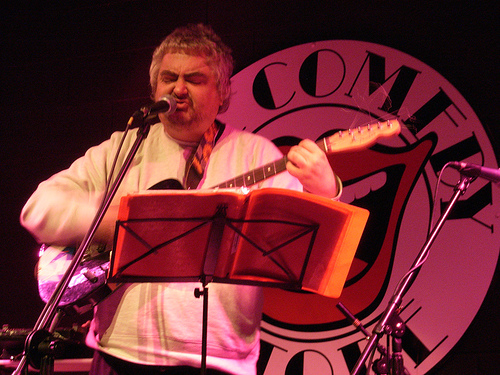

In [25]:

from IPython.display import Image
import matplotlib.pyplot as plt
import random, os
path = r"C:\Users\modam\.cache\kagglehub\datasets\huanghanchina\pascal-voc-2012\versions\1\VOCdevkit\VOC2012"

img_path = os.path.join(path, 'VOC2012', 'JPEGImages' , random.choice(os.listdir(os.path.join(path, 'VOC2012', 'JPEGImages'))))
Image(img_path)

In [50]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.patches as patches
idx = torch.randint(0, len(dataset_val), (1,)).item()
img, target = dataset_val[idx]

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms.functional import to_pil_image

def visualize_prediction(img, target, outputs, score_thresh=0.5):
    # remove batch dimension
    img_vis = img.squeeze(0).cpu()

    # de-normalize
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img_vis = img_vis * std + mean
    img_vis = img_vis.clamp(0, 1)

    # prepare figure
    fig, ax = plt.subplots(1, figsize=(8,8))
    ax.imshow(to_pil_image(img_vis))
    ax.set_title("Green = Predicted & Red = Ground Truth")

    H, W = img_vis.shape[1:]
    scale = torch.tensor([W, H, W, H])

    # predicted boxes
    pred_boxes = outputs['pred_boxes'][0].cpu()
    pred_logits = outputs['pred_logits'][0].softmax(-1).cpu()
    scores, labels = pred_logits.max(-1)
    keep = scores > score_thresh

    for b in pred_boxes[keep]:
        x1, y1, x2, y2 = (b * scale).tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)

    # ground truth boxes
    for b in target['boxes'].cpu():
        x1, y1, x2, y2 = (b * scale).tolist()
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()


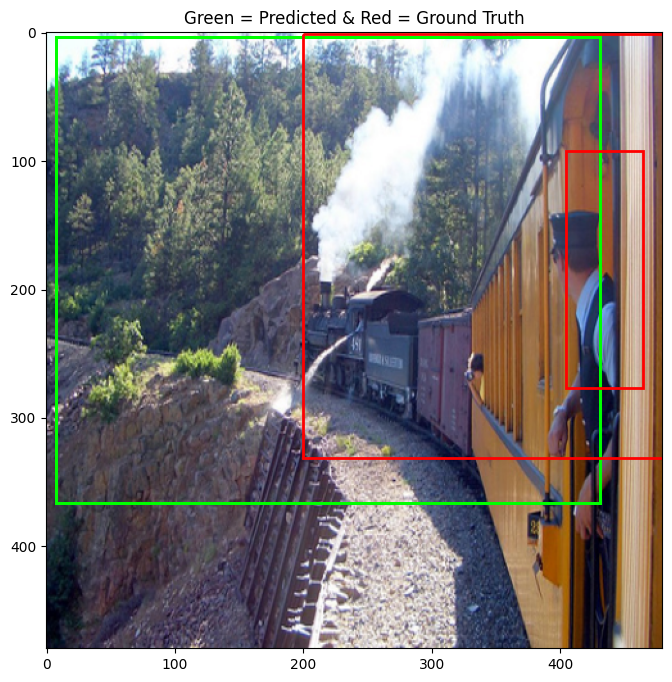

In [54]:
visualize_prediction(img, target, outputs)
